In [29]:
import cPickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from string import punctuation
import xgboost as xgb

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc

from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline


In [30]:
# See nice example from 
# https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

# Also RunMutliclassOneVRest

### Function Definitions

In [31]:
#from http://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn


stemmer = SnowballStemmer("english")

def stem_tokens(tokens, stemmer):
    stemmed=[]
    for item in tokens:
        
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

    

In [32]:
# write function to grab the feature importances & show top ~20

def top_features(d, n=20):
    '''
    Function to show the top n important features & their scores.
    The get_fscore method in xgboost returns a dictionary of features & a number.
    Get the top n features with the highest scores
    
    d is a dictionary (from get_fscore method in xgboost)
    '''
    
    featureslist = []
    
    for k, v in sorted(d.iteritems(), reverse=True, key=lambda (k,v): (v,k)):
        featureslist.append((k,v))
    
    return featureslist[:n]
    
 

In [33]:
# write function to grab the feature importances & show top ~20

def top_features_words(d,vect, n=20):
    '''
    Function to show the top n important features, their scores,and corresponding words.
    The get_fscore method in xgboost returns a dictionary of features & a number.
    Get the top n features with the highest scores
    
    d is a dictionary (from bst.get_fscore() in xgboost)
    vect is the instantiated vectorizer (e.g. vect = TfidfVectorizer(stuff); not the fitted variable name)
    '''
    
    # Back out important features

    dicta = vect.vocabulary_
    dictb = dict ( (v,k) for k, v in dicta.items() )
    # dictb[featurenum] returns the word.

    featureslist = []
    for k, v in sorted(d.iteritems(), reverse=True, key=lambda (k,v): (v,k)):
        featureslist.append((k,v))
    
    topfeatures = []
    for i in xrange(n):
        fname = featureslist[i][0]
        fnum=int(filter(lambda x: x.isdigit(),fname))
        topfeatures.append((featureslist[i][0],featureslist[i][1],dictb[fnum]))
    
    return topfeatures
    

In [34]:
def createmulticlassROC(classes, y_test, y_score):
    '''
    Function to create & plot ROC curve & associated areas
    Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    Inputs: classes: a list of classes
            y_test: the test labels, binarized into columns
            y_score: the predicted probabilities for each class.   
                (e.g. y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test) )
    '''
    
    # Compute ROC curve and ROC area for each class
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize = (12,8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Predicting Hate Speech')
    plt.legend(loc="lower right")
    plt.show()

### Load Data

In [35]:
X_stripped = pickle.load(open('../Data/X_stripped.p', 'rb'))
y = pickle.load(open('../Data/y.p', 'rb'))
# X = pickle.load(open('../Data/X.p', 'rb'))

In [ ]:
### Load & Save out

# # Load data
# df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))
# X = df.body
# # use apply fuction to strip puctuation from X
# X_stripped = X.apply(lambda x: ''.join([l for l in x if l not in punctuation]))
# y = df.label
# #Save out just X, X_stripped & y
# pickle.dump(X, open('../Data/X.p', 'wb'))
# pickle.dump(X_stripped, open('../Data/X_stripped.p', 'wb'))
# pickle.dump(y, open('../Data/y.p', 'wb'))


In [36]:
classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']
n_classes = len(classes)

In [37]:
# Relabel the output, integers [0-4], for xgboost
# e.g. for 0: df.ix[(df.label=='NotHate'),'label'] = '0'

for ind in range(len(classes)):
    y[(y==classes[ind])] = int(ind)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_stripped, y, test_size=0.3, random_state=42)

In [39]:
# Binarize ylabel (y_test), so we can call multiclass roc plot
# Need to cast y_test as an int.
ylabel_bin = label_binarize(y_test.astype(int), classes=[0,1,2,3,4],sparse_output=False)

### End Load Data

In [68]:
# Had some problems with label_binarize--wanted to probe type_of_target in this cell to see if that was the issue
# (It was.)
from sklearn.utils.multiclass import type_of_target
type_of_target(y_test.astype(int))

'multiclass'

In [96]:
np.array(y_test).shape

(473426,)

In [76]:
# y_test

#### Use Count Vectorizer

In [ ]:
# Model notes:
#  CV with 10,000 features, no tokenizing, english stop words --> AUC = 0.644
#  CV with 20,000 features, no tokenizing, english stop words --> AUC = 0.644
#  CV with 5,000 features, no tokenizing, english stop words --> AUC = 0.642
#  CV with 5,000 features, no tokenizing, english stop words, eta = 0.3 --> 0.666
#  CV with 5,000 features, no tokenizing, english stop words, eta = 0.9 --> 0.710
# Assuming english stop words
#  CV with 5,000 features, no tokenizing, max_depth = 4 , eta = 0.9 --> 0.687  (stick to max depth = 6)



In [215]:
countv = CountVectorizer(decode_error = 'ignore', stop_words = 'english',max_features=5000, tokenizer=None)
# countv = CountVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=5000, tokenizer=None)

In [216]:
#Training vectors
countv_fit_X_train = countv.fit_transform(X_train)
#test vectora
countv_fit_X_test = countv.transform(X_test)

In [116]:
y_train.value_counts()

0    708151
1    222053
2    133035
3     37368
4      4052
Name: label, dtype: int64

In [217]:
xg_train = xgb.DMatrix(countv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(countv_fit_X_test, label=y_test)

In [222]:
# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.9
param['max_depth'] = 4
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test );

# #reshape y_test
# ytestlen = y_test.shape[0]
# y_test.reshape( ytestlen, 1 )

print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

[0]	train-merror:0.314597	test-merror:0.312704
[1]	train-merror:0.307330	test-merror:0.305186
[2]	train-merror:0.300204	test-merror:0.298412
[3]	train-merror:0.295704	test-merror:0.293991


predicting, classification error=0.291256


[4]	train-merror:0.292797	test-merror:0.291256


In [223]:
# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

[0]	train-merror:0.314597	test-merror:0.312704
[1]	train-merror:0.307330	test-merror:0.305186
[2]	train-merror:0.300204	test-merror:0.298412
[3]	train-merror:0.295704	test-merror:0.293991


predicting, classification error=0.291256


[4]	train-merror:0.292797	test-merror:0.291256


<IPython.core.display.Javascript object>


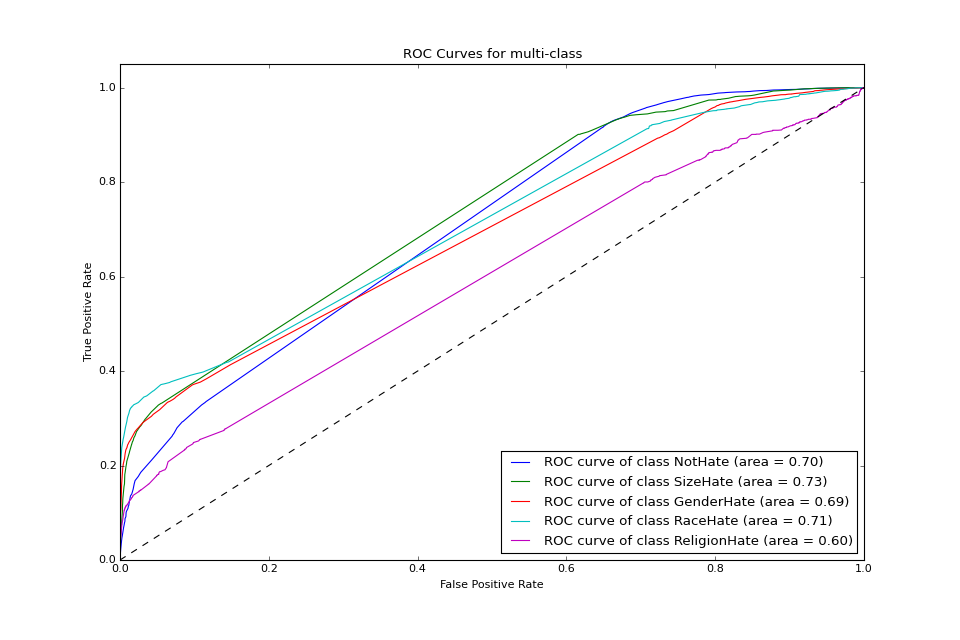

average AUC: 0.687091573998


In [224]:
createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))


In [221]:
top_features(bst.get_fscore(), n=30)

[('f1726', 36),
 ('f3263', 31),
 ('f4890', 24),
 ('f2051', 21),
 ('f4923', 15),
 ('f2659', 14),
 ('f1975', 14),
 ('f3034', 13),
 ('f1935', 12),
 ('f1933', 12),
 ('f1931', 12),
 ('f1734', 12),
 ('f539', 11),
 ('f4872', 11),
 ('f3033', 11),
 ('f2482', 11),
 ('f2480', 11),
 ('f540', 10),
 ('f507', 10),
 ('f1907', 10),
 ('f1391', 10),
 ('f4891', 9),
 ('f4638', 9),
 ('f4106', 9),
 ('f2515', 9),
 ('f1763', 9),
 ('f4524', 8),
 ('f682', 6),
 ('f4107', 6),
 ('f3912', 6)]

### Use TF-IDF

In [ ]:
# Model notes
#  TFIDF with english stop words, 10,000 features, no tokenizing --> avg AUC = .6436
#  TFIDF with english stop words, 20,000 features, no tokenizing --> avg AUC = .6441
#  TFIDF with english stop words, 1000 features, no tokenizing --> avg AUC = .6349
#  TFIDF with english stop words, 50,000 features, no tokenizing --> avg AUC = .6447
#  TFIDF with english stop words, 5000 features, no tokenizing --> avg AUC = .6416
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.35 --> avg AUC = .676
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.4 --> avg AUC = .676
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.5 --> avg AUC = .685
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.7 --> avg AUC = .702
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.9 --> avg AUC = .712
#  TFIDF with english stop words, 10,000 features, no tokenizing, eta = 0.9 --> avg AUC = .715
#  TFIDF with english stop words, 5,000 features, WITH tokenizing/snowball, eta = 0.9 --> avg AUC = .735

#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.95 --> avg AUC = .712 --> use eta=0.9





In [211]:
tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=5000, tokenizer=None)

In [212]:
#Training vectors
tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
#test vectors
tfidfv_fit_X_test = tfidfv.transform(X_test)

In [213]:
xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)
# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test );

# #reshape y_test
# ytestlen = y_test.shape[0]
# y_test.reshape( ytestlen, 1 )

print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))
# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))


[0]	train-merror:0.306409	test-merror:0.304884
[1]	train-merror:0.298475	test-merror:0.297037
[2]	train-merror:0.292203	test-merror:0.291006
[3]	train-merror:0.287473	test-merror:0.286674
[4]	train-merror:0.282943	test-merror:0.282747
[0]	train-merror:0.306409	test-merror:0.304884
[1]	train-merror:0.298475	test-merror:0.297037
[2]	train-merror:0.292203	test-merror:0.291006
[3]	train-merror:0.287473	test-merror:0.286674
[4]	train-merror:0.282943	test-merror:0.282747


predicting, classification error=0.282747
predicting, classification error=0.282747


<IPython.core.display.Javascript object>


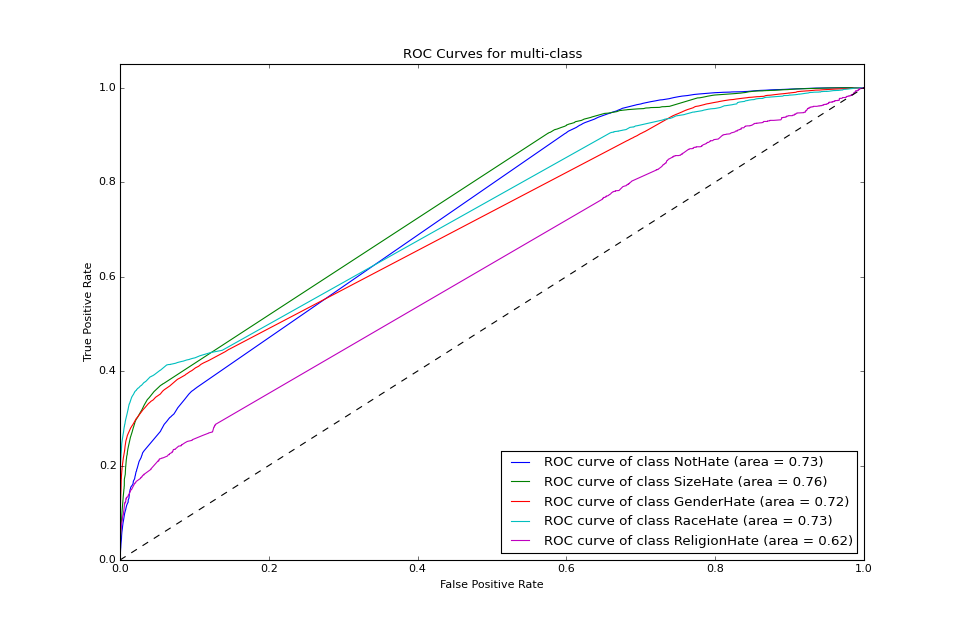

average AUC: 0.711991417256


In [214]:
createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))


In [236]:
top_features(bst.get_fscore(), n=30)

[('f1726', 18),
 ('f3034', 12),
 ('f2051', 12),
 ('f4872', 10),
 ('f2480', 10),
 ('f4890', 8),
 ('f1935', 8),
 ('f1933', 8),
 ('f3263', 7),
 ('f3033', 7),
 ('f1975', 7),
 ('f1391', 7),
 ('f2482', 6),
 ('f1734', 6),
 ('f1691', 6),
 ('f1931', 5),
 ('f540', 4),
 ('f4891', 4),
 ('f4106', 4),
 ('f2711', 4),
 ('f1907', 4),
 ('f568', 3),
 ('f507', 3),
 ('f4923', 3),
 ('f4524', 3),
 ('f4042', 3),
 ('f2848', 3),
 ('f2437', 3),
 ('f2230', 3),
 ('f1945', 3)]

<IPython.core.display.Javascript object>


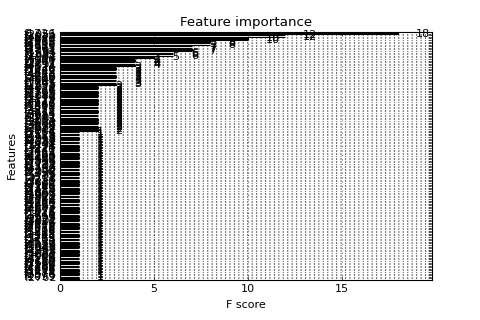

In [237]:
%matplotlib notebook
#figure(figsize(12,8))
xgb.plot_importance(bst)

In [227]:
# Back out important features
dicta = tfidfv.vocabulary_
dictb = dict ( (v,k) for k, v in dicta.items() )
dictb[4872]  #put in the feature # here to get the word back

u'weight'

In [ ]:
tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=1000, tokenizer=tokenize)

#Training vectors
tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
pickle.dump(tfidfv_fit_X_train, open('tfidf1000_fittrans_X_train.p', 'wb'))

#test vectora
tfidfv_fit_X_test = tfidfv.transform(X_test)
pickle.dump(tfidfv_fit_X_test, open('tfidf1000_fit_X_test.p', 'wb'))


xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)

[0]	train-merror:0.305857	test-merror:0.304485
[1]	train-merror:0.301198	test-merror:0.300288
[2]	train-merror:0.296273	test-merror:0.295791
[3]	train-merror:0.293085	test-merror:0.292975
[4]	train-merror:0.290902	test-merror:0.291127
[5]	train-merror:0.289348	test-merror:0.289914
[6]	train-merror:0.288431	test-merror:0.289194
[7]	train-merror:0.287221	test-merror:0.288239
[8]	train-merror:0.286097	test-merror:0.287255
[9]	train-merror:0.285170	test-merror:0.286442


predicting, classification error=0.286442


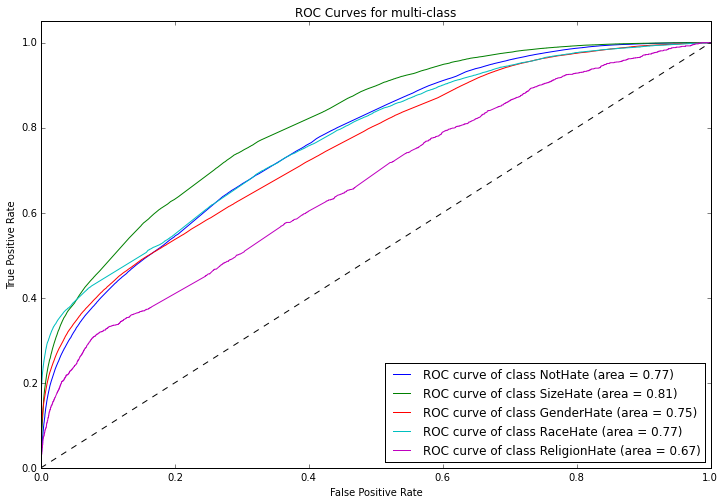

average AUC: 0.755420099775


In [12]:
# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 10

# output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

In [14]:
top_features_words(bst.get_fscore(),tfidfv, n=20)

[('f15', 90, u','),
 ('f18', 85, u'.'),
 ('f355', 72, u'fat'),
 ('f976', 45, u'white'),
 ('f9', 45, u"'s"),
 ('f625', 42, u'nigger'),
 ('f674', 37, u'peopl'),
 ('f614', 37, u"n't"),
 ('f391', 36, u'game'),
 ('f137', 36, u'black'),
 ('f6', 33, u"''"),
 ('f504', 32, u'jew'),
 ('f39', 27, u'?'),
 ('f542', 26, u'like'),
 ('f385', 26, u'fuck'),
 ('f968', 25, u'weight'),
 ('f37', 21, u';'),
 ('f982', 20, u'women'),
 ('f636', 19, u'obes'),
 ('f510', 19, u'just')]

[0]	train-merror:0.305857	test-merror:0.304485
[1]	train-merror:0.301198	test-merror:0.300288
[2]	train-merror:0.296273	test-merror:0.295791
[3]	train-merror:0.293085	test-merror:0.292975
[4]	train-merror:0.290902	test-merror:0.291127
[5]	train-merror:0.289348	test-merror:0.289914
[6]	train-merror:0.288431	test-merror:0.289194
[7]	train-merror:0.287221	test-merror:0.288239
[8]	train-merror:0.286097	test-merror:0.287255
[9]	train-merror:0.285170	test-merror:0.286442
[10]	train-merror:0.284536	test-merror:0.286049
[11]	train-merror:0.283785	test-merror:0.285417
[12]	train-merror:0.283344	test-merror:0.285130
[13]	train-merror:0.282862	test-merror:0.284651
[14]	train-merror:0.281811	test-merror:0.283785
[15]	train-merror:0.281412	test-merror:0.283489
[16]	train-merror:0.280688	test-merror:0.283009
[17]	train-merror:0.279627	test-merror:0.282285
[18]	train-merror:0.279210	test-merror:0.281981
[19]	train-merror:0.278653	test-merror:0.281647


predicting, classification error=0.281647


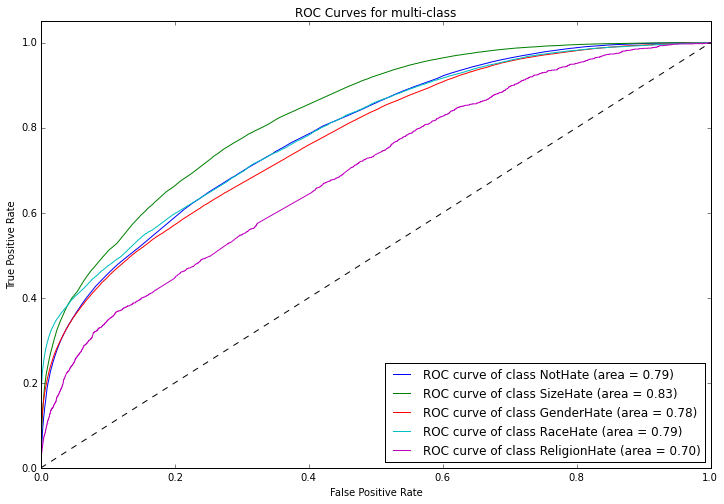

average AUC: 0.776570542655


[('f18', 206, u'.'),
 ('f15', 182, u','),
 ('f355', 108, u'fat'),
 ('f9', 93, u"'s"),
 ('f614', 86, u"n't"),
 ('f39', 68, u'?'),
 ('f674', 63, u'peopl'),
 ('f976', 58, u'white'),
 ('f542', 54, u'like'),
 ('f6', 53, u"''"),
 ('f391', 50, u'game'),
 ('f625', 48, u'nigger'),
 ('f137', 46, u'black'),
 ('f385', 45, u'fuck'),
 ('f504', 41, u'jew'),
 ('f982', 40, u'women'),
 ('f510', 40, u'just'),
 ('f968', 38, u'weight'),
 ('f636', 34, u'obes'),
 ('f37', 30, u';')]

In [15]:

# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 20

# output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

top_features_words(bst.get_fscore(),tfidfv, n=20)

### Started stripping punctuation here & below

In [96]:
tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=1000, tokenizer=tokenize)

#Training vectors
tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
pickle.dump(tfidfv_fit_X_train, open('tfidf1000_puncstrip_fittrans_X_train.p', 'wb'))

#test vectora
tfidfv_fit_X_test = tfidfv.transform(X_test)
pickle.dump(tfidfv_fit_X_test, open('tfidf1000_puncstrip_fit_X_test.p', 'wb'))


xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)

[0]	train-merror:0.307649	test-merror:0.306054
[1]	train-merror:0.299728	test-merror:0.298532
[2]	train-merror:0.296513	test-merror:0.295687
[3]	train-merror:0.293568	test-merror:0.292964
[4]	train-merror:0.291590	test-merror:0.291315
[5]	train-merror:0.290261	test-merror:0.290322
[6]	train-merror:0.289154	test-merror:0.289581
[7]	train-merror:0.287757	test-merror:0.288189
[8]	train-merror:0.286466	test-merror:0.286951
[9]	train-merror:0.285662	test-merror:0.286140
[10]	train-merror:0.285104	test-merror:0.285798
[11]	train-merror:0.284043	test-merror:0.284989
[12]	train-merror:0.283181	test-merror:0.284384
[13]	train-merror:0.282704	test-merror:0.284104
[14]	train-merror:0.282254	test-merror:0.283795
[15]	train-merror:0.281811	test-merror:0.283499
[16]	train-merror:0.281017	test-merror:0.282997
[17]	train-merror:0.280110	test-merror:0.282145
[18]	train-merror:0.279309	test-merror:0.281527
[19]	train-merror:0.278806	test-merror:0.281094
[20]	train-merror:0.278412	test-merror:0.280859
[2

predicting, classification error=0.272539


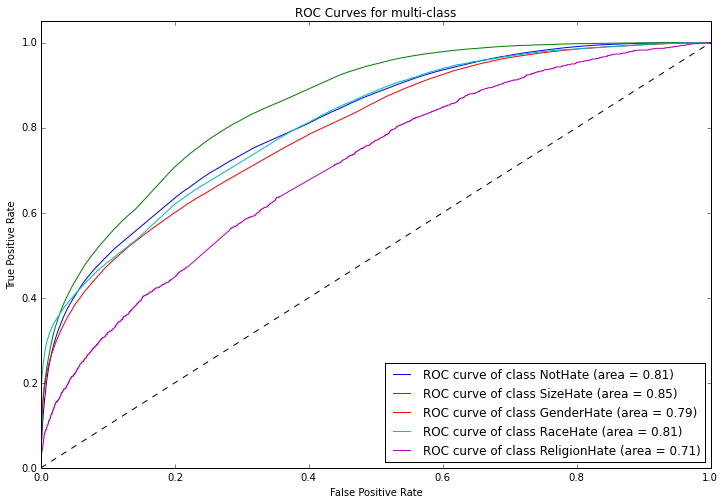

average AUC: 0.793541279946


[('f656', 256, u'peopl'),
 ('f524', 252, u'like'),
 ('f491', 215, u'just'),
 ('f329', 199, u'fat'),
 ('f259', 169, u'dont'),
 ('f359', 163, u'fuck'),
 ('f972', 136, u'white'),
 ('f447', 135, u'im'),
 ('f87', 116, u'becaus'),
 ('f977', 115, u'women'),
 ('f548', 112, u'make'),
 ('f903', 99, u'think'),
 ('f365', 88, u'game'),
 ('f107', 85, u'black'),
 ('f962', 81, u'weight'),
 ('f790', 81, u'say'),
 ('f485', 81, u'jew'),
 ('f685', 80, u'post'),
 ('f275', 72, u'eat'),
 ('f902', 65, u'thing')]

In [99]:
#Model XGBoost1000strip_80rounds

# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 80

# output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

top_features_words(bst.get_fscore(),tfidfv, n=20)

In [100]:
bst.save_model('XGBoost1000strip_80rounds.model')
#https://xgboost.readthedocs.org/en/latest/python/python_intro.html

[0]	train-merror:0.307649	test-merror:0.306054
[1]	train-merror:0.305380	test-merror:0.303952
[2]	train-merror:0.300487	test-merror:0.299392
[3]	train-merror:0.300786	test-merror:0.299745
[4]	train-merror:0.299501	test-merror:0.298682
[5]	train-merror:0.297790	test-merror:0.297058
[6]	train-merror:0.296985	test-merror:0.296374
[7]	train-merror:0.296281	test-merror:0.295791
[8]	train-merror:0.295375	test-merror:0.295020
[9]	train-merror:0.293839	test-merror:0.293395
[10]	train-merror:0.292952	test-merror:0.292796
[11]	train-merror:0.292250	test-merror:0.292320
[12]	train-merror:0.291629	test-merror:0.291687
[13]	train-merror:0.291302	test-merror:0.291382
[14]	train-merror:0.290746	test-merror:0.291040
[15]	train-merror:0.289872	test-merror:0.289931
[16]	train-merror:0.289032	test-merror:0.289156
[17]	train-merror:0.288526	test-merror:0.288717
[18]	train-merror:0.287830	test-merror:0.288180
[19]	train-merror:0.287530	test-merror:0.287918
[20]	train-merror:0.286206	test-merror:0.286683
[2

predicting, classification error=0.280367


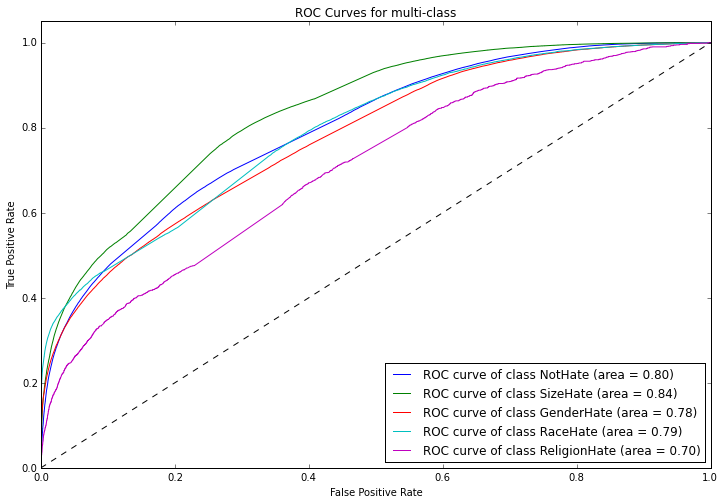

average AUC: 0.780841247616


[('f329', 176, u'fat'),
 ('f656', 174, u'peopl'),
 ('f524', 155, u'like'),
 ('f972', 140, u'white'),
 ('f491', 116, u'just'),
 ('f359', 113, u'fuck'),
 ('f485', 99, u'jew'),
 ('f259', 99, u'dont'),
 ('f977', 95, u'women'),
 ('f107', 91, u'black'),
 ('f607', 90, u'nigger'),
 ('f962', 77, u'weight'),
 ('f618', 70, u'obes'),
 ('f87', 65, u'becaus'),
 ('f790', 64, u'say'),
 ('f903', 61, u'think'),
 ('f447', 61, u'im'),
 ('f275', 55, u'eat'),
 ('f365', 52, u'game'),
 ('f567', 51, u'men')]

In [98]:
# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.5          #<<<---- THE MAIN DIFFERENCE FROM ABOVE
param['max_depth'] = 6
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 40

# output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

top_features_words(bst.get_fscore(),tfidfv, n=20)

### For max_features=500 (AUC .765, after 100) --> Did worse than max_features=1000 (.AUC .793, at 80 rounds)
### max_features=2000: (AUC .809, after 100)
### Max_features=4000: Auc = .825, after 100
### Max_features=8000: AUC = 0.835, after 100
### Max_features=3000: AUC = 0.825 after 310 rounds of boosting
### max_featres = 4000, max depth = 9: AUC =  .832 after ~210 rounds

In [22]:
tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=3000, tokenizer=tokenize)

#Training vectors
tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
pickle.dump(tfidfv_fit_X_train, open('../Data/tfidf3000_puncstrip_X_train.p', 'wb'))

#test vectora
tfidfv_fit_X_test = tfidfv.transform(X_test)
pickle.dump(tfidfv_fit_X_test, open('../Data/tfidf3000_puncstrip_X_test.p', 'wb'))

In [ ]:
# tfidfv_X_train = pickle.load(open('tfidf1000_fittrans_X_train.p', 'rb'))
# tfidfv_X_test = pickle.load(open('tfidf1000_fittrans_X_train.p', 'rb'))

In [23]:
xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)

Will train until test error hasn't decreased in 5 rounds.
[0]	train-merror:0.303219	test-merror:0.301460
[1]	train-merror:0.296319	test-merror:0.295089
[2]	train-merror:0.292174	test-merror:0.291311
[3]	train-merror:0.288492	test-merror:0.288034
[4]	train-merror:0.284977	test-merror:0.284830
[5]	train-merror:0.281251	test-merror:0.281237
[6]	train-merror:0.279078	test-merror:0.279343
[7]	train-merror:0.277443	test-merror:0.278109
[8]	train-merror:0.275888	test-merror:0.276846
[9]	train-merror:0.274970	test-merror:0.276138
[10]	train-merror:0.273305	test-merror:0.274636
[11]	train-merror:0.272308	test-merror:0.273906
[12]	train-merror:0.270719	test-merror:0.272704
[13]	train-merror:0.269927	test-merror:0.271928
[14]	train-merror:0.269217	test-merror:0.271341
[15]	train-merror:0.268595	test-merror:0.270784
[16]	train-merror:0.268009	test-merror:0.270315
[17]	train-merror:0.267306	test-merror:0.269797
[18]	train-merror:0.266790	test-merror:0.269457
[19]	train-merror:0.266145	test-merror:0

predicting, classification error=0.245876


[309]	train-merror:0.220235	test-merror:0.245876
Stopping. Best iteration:
[304]	train-merror:0.220483	test-merror:0.245825



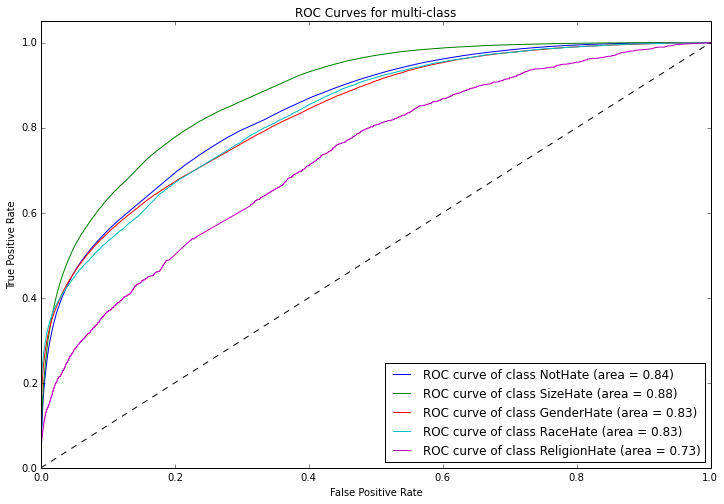

average AUC: 0.825065382025


[('f1601', 824, u'like'),
 ('f1948', 745, u'peopl'),
 ('f1515', 724, u'just'),
 ('f838', 488, u'dont'),
 ('f1039', 428, u'fat'),
 ('f1376', 369, u'im'),
 ('f293', 353, u'becaus'),
 ('f2686', 325, u'think'),
 ('f1141', 316, u'fuck'),
 ('f1647', 295, u'make'),
 ('f2320', 262, u'say'),
 ('f2922', 236, u'white'),
 ('f1536', 233, u'know'),
 ('f2685', 216, u'thing'),
 ('f1201', 212, u'good'),
 ('f2943', 211, u'women'),
 ('f1870', 208, u'onli'),
 ('f1622', 207, u'look'),
 ('f2878', 202, u'want'),
 ('f2817', 202, u'use')]

In [24]:
#max_features = 3000 
# Set up xboost parameters
param = {}
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5
# output probabilities from softmax fn
param['objective'] = 'multi:softprob'

watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]

num_round = 500



bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=5)
#bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

top_features_words(bst.get_fscore(),tfidfv, n=20)

In [26]:
bst.save_model('XGBoost3000strip_310rounds.model')

In [40]:
# tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=4000, tokenizer=tokenize)

# #Training vectors
# tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
# pickle.dump(tfidfv_fit_X_train, open('../Data/tfidf4000_puncstrip_X_train.p', 'wb'))

# #test vectora
# tfidfv_fit_X_test = tfidfv.transform(X_test)
# pickle.dump(tfidfv_fit_X_test, open('../Data/tfidf4000_puncstrip_X_test.p', 'wb'))

tfidfv_fit_X_train = pickle.load(open('../Data/tfidf4000_puncstrip_X_train.p', 'rb'))
tfidfv_fit_X_test = pickle.load(open('../Data/tfidf4000_puncstrip_X_test.p', 'rb'))

xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)

Will train until test error hasn't decreased in 5 rounds.
[0]	train-merror:0.297314	test-merror:0.296638
[1]	train-merror:0.288450	test-merror:0.288396
[2]	train-merror:0.281753	test-merror:0.282712
[3]	train-merror:0.276844	test-merror:0.278403
[4]	train-merror:0.272274	test-merror:0.274668
[5]	train-merror:0.269763	test-merror:0.272740
[6]	train-merror:0.267127	test-merror:0.270553
[7]	train-merror:0.265238	test-merror:0.269140
[8]	train-merror:0.263623	test-merror:0.267774
[9]	train-merror:0.262115	test-merror:0.266798
[10]	train-merror:0.260705	test-merror:0.265653
[11]	train-merror:0.259576	test-merror:0.264823
[12]	train-merror:0.258277	test-merror:0.263963
[13]	train-merror:0.257379	test-merror:0.263279
[14]	train-merror:0.256249	test-merror:0.262485
[15]	train-merror:0.255264	test-merror:0.261741
[16]	train-merror:0.254400	test-merror:0.261367
[17]	train-merror:0.253532	test-merror:0.260774
[18]	train-merror:0.252741	test-merror:0.260150
[19]	train-merror:0.251847	test-merror:0

predicting, classification error=0.240392


Stopping. Best iteration:
[211]	train-merror:0.204505	test-merror:0.240375



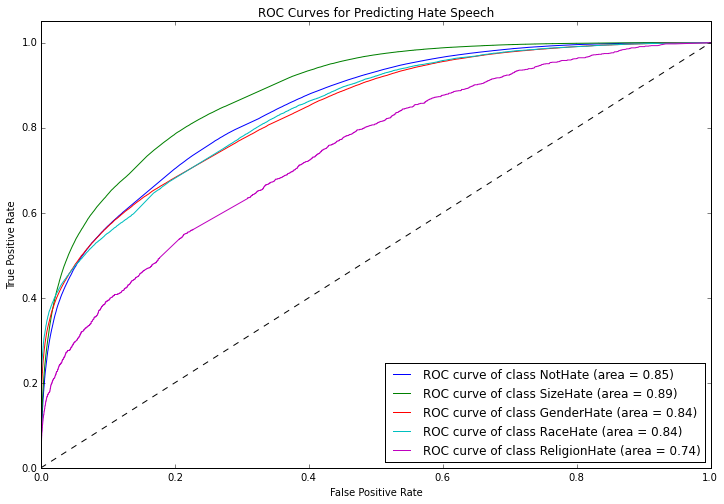

average AUC: 0.832021299915


KeyError: 3599

In [41]:
# max_features = 4000
# Set up xboost parameters
param = {}
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 9  #increased from 6 previously
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5
# output probabilities from softmax fn
param['objective'] = 'multi:softprob'

watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]

num_round = 400


bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=5)
#bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

top_features_words(bst.get_fscore(),tfidfv, n=20)

In [ ]:
bst.save_model('XGBoost4000strip_400maxrounds.model')

In [17]:
ylabel.size

473426

In [18]:
y_test.shape

(473426,)

In [19]:
tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=8000, tokenizer=tokenize)

#Training vectors
tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
pickle.dump(tfidfv_fit_X_train, open('../Data/tfidf8000_puncstrip_X_train.p', 'wb'))

#test vectora
tfidfv_fit_X_test = tfidfv.transform(X_test)
pickle.dump(tfidfv_fit_X_test, open('../Data/tfidf8000_puncstrip_X_test.p', 'wb'))


xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)

Will train until test error hasn't decreased in 5 rounds.
[0]	train-merror:0.303529	test-merror:0.301872
[1]	train-merror:0.296335	test-merror:0.295034
[2]	train-merror:0.290443	test-merror:0.289479
[3]	train-merror:0.286849	test-merror:0.286127
[4]	train-merror:0.283100	test-merror:0.282824
[5]	train-merror:0.279008	test-merror:0.278857
[6]	train-merror:0.276362	test-merror:0.276417
[7]	train-merror:0.274016	test-merror:0.274260
[8]	train-merror:0.272183	test-merror:0.272522
[9]	train-merror:0.270588	test-merror:0.271086
[10]	train-merror:0.268912	test-merror:0.269417
[11]	train-merror:0.267375	test-merror:0.268376
[12]	train-merror:0.266196	test-merror:0.267410
[13]	train-merror:0.265075	test-merror:0.266549
[14]	train-merror:0.263135	test-merror:0.264730
[15]	train-merror:0.262189	test-merror:0.263908
[16]	train-merror:0.261320	test-merror:0.263245
[17]	train-merror:0.260608	test-merror:0.262622
[18]	train-merror:0.259992	test-merror:0.262246
[19]	train-merror:0.259176	test-merror:0

predicting, classification error=0.241662


[99]	train-merror:0.231047	test-merror:0.241662


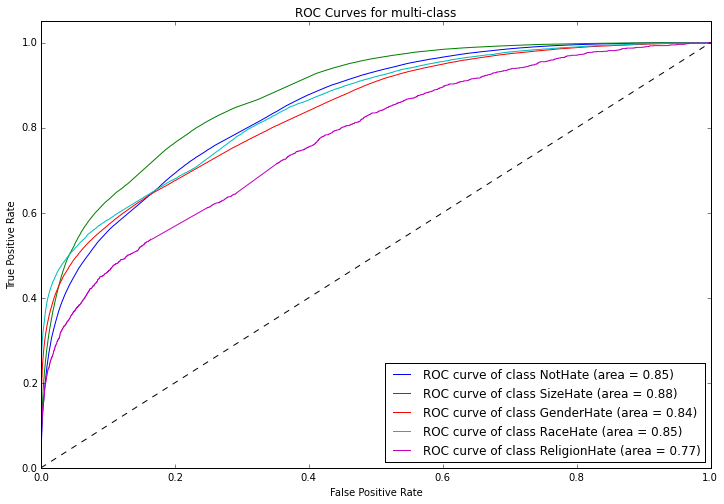

average AUC: 0.835409188061


[('f2709', 293, u'fat'),
 ('f4234', 276, u'like'),
 ('f5276', 273, u'peopl'),
 ('f4016', 227, u'just'),
 ('f2251', 175, u'dont'),
 ('f7809', 164, u'white'),
 ('f835', 138, u'becaus'),
 ('f2996', 134, u'game'),
 ('f2956', 126, u'fuck'),
 ('f7876', 110, u'women'),
 ('f930', 108, u'black'),
 ('f3639', 105, u'im'),
 ('f7152', 96, u'think'),
 ('f6213', 87, u'say'),
 ('f7769', 86, u'weight'),
 ('f4845', 85, u'nigger'),
 ('f7718', 81, u'want'),
 ('f3966', 81, u'jew'),
 ('f4361', 80, u'make'),
 ('f7196', 77, u'time')]

In [20]:
# 8000 max_features
# Set up xboost parameters
param = {}
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
# param['nthread'] = 4
param['num_class'] = 5
# output probabilities from softmax fn
param['objective'] = 'multi:softprob'

watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]

num_round = 100


bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=5)
#bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))

top_features_words(bst.get_fscore(),tfidfv, n=20)